# Fasting Pandas - A guide into optimizing your analytical processing 

### Part 1

---

The following notebooks aim to display how we can manipulate data and dataframes more effectively. Their purpose is to serve as a guideline in how we can approach a problem different ways, and how we can measure the impact it has on the machine resources.

We should understand that in some ocassions suboptimal code will not cost us only time, but money aswell.

Here we go.

In [1]:
import pandas as pd
import numpy as np
from fasting_pandas import datasets as ds
from statistics import mean
from matplotlib import pyplot

<module 'fasting_pandas.datasets' from 'd:\\Proyectos\\datakai\\projects\\github\\datakaicr\\public\\fasting-pandas\\fasting_pandas\\datasets.py'>

### Datasets
In order to minimize the size of the repo we will be generating the dataframes ourselves. You can take a look at them in the datasets module. All dataframes default to a size of 10,000 rows but you can change it if you wish.

We will start by generating a score dataframe.

In [2]:
df = ds.generate_scores()
df.shape[0]

10000

### The Problem
For our first example we will work with data from a group of high school students between ages of 12 and 19 and their average daily time spent studying for their tests. We have the scores for 3 tests, and want to reward them with happy food if they did well.

Obviously, this is random data so don't expect too much coherence. For our purposes we don't care about this.

Let's start simple.

Reward calculation:
- If they studied for more than 3 hours a day and scored higher than 90 on test 1 they get happy food
- If they failed test 1 they get sad food
- If they passsed the first test (higher or equal to 65) and are in the age group between 12 and 13 they get happy food
- Everyone else gets sad food :(

So we want to define a function that uses conditional logic in order to determine who gets a positive or negative reward. One of the usual approaches is to define a function that takes care of that logic, and then check if the condition is met for every row.


In [3]:
df.head()

,age,study_time,test_1_score,test_2_score,test_3_score,happy_food,sad_food
0,14,10,0.346058,0.746685,0.337483,fried-chicken,broccoli
1,14,8,0.964345,0.614264,0.683549,pizza,soup
2,17,6,0.452403,0.942057,0.598630,hamburguer,beans
3,18,5,0.914480,0.183955,0.921535,grilled-meat,broccoli
4,12,9,0.039367,0.235512,0.455845,nachos,beef-liver


In [4]:
def my_reward(row):
    if (row['study_time'] >= 4) & (row['test_1_score'] >= 0.9):
        return row['happy_food']
    elif (row['test_1_score'] >= 0.65) & (row['age'] <= 13):
        return row['happy_food']
    return row['sad_food']

### Using For-Loops

Lets see what happens when we iterate through each row of the dataframe.

We can measure our results in several ways. One would be to create a wrapper function that measures time and use it for each of the functions we will be applying. You can find this function in the helper module. However for simplicity purposes we will use the %timeit magic method and save the results in a function that we can later access to calculate the mean() and store the results for later usage. 

In [5]:
test1_time = %timeit -o for index, row in df.iterrows(): \
        df.loc[index, 'reward'] = my_reward(row)

1.21 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So more than a second to calculate two main conditions and a default on a couple of colums for only 10,000 rows. 

Yep, this is bad. Moving on.

## Apply

If you have used pandas for more than a day, you have probably learned about the apply method. We can use this method by proving our function and doing the calculation directly on each column. Dataframes are much faster when used this way.

Let's see how fast.

In [6]:
test2_time = %timeit -o df['reward'] = df.apply(my_reward, axis = 1)

92.7 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Just by using a DataFrame method we get much better results. Seems we need to learn to leverage what pandas offers to us first instead of diving into the problem head first, that is if we want our solution to scale properly (Hint: We usually do).

We calculate our percentage difference the usual way.

In [7]:
abs((mean(test2_time.timings) / mean(test1_time.timings)) - 1)

0.9233299571285543

90%. Let's go.

## Vectorization

If you don't know what vectorization is, then google is your friend. On summary, when using vectors we don't care about the order of operations. This means we can apply our function on multiple arrays all at once.

Pandas has some vectorized methods which are:
- groupby
- filter
- transform
- Column arithmetic (+,-/*)
- .str methods
- pd.to_datetime()

We use vectorization when:
1. We want to avoid looping over the dataset
2. We want to operate on an array simultaneously
3. We can leverage numpy to push our operation into C level for-loops

So for our example we want to vectorize our logical statements. How do we do this?

Well, two ways. We can either filter our dataframe with loc and apply the conditionals, or use...

numpy.where()

Numpy is your friend. We can use numpy to vectorize our if / else statements to get faster results. It's also cleaner.

I'll show you both.

In [8]:
def test3():
    df['reward'] = df['sad_food'] 
    df.loc[
            (df['study_time'] >= 4) & (df['test_1_score'] >= 0.9) | 
            (df['test_1_score'] >= 0.65) & (df['age'] <= 13)
            , 'reward'
    ]  = df['happy_food']

In [9]:
test3_time = %timeit -o df['reward'] = test3()

937 µs ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now we are getting into nanosecond territory. Let's look at numpy

In [10]:
def test4():
    df['reward'] = np.where(
        (df['study_time'] >= 4) & (df['test_1_score'] >= 0.9) | (df['test_1_score'] >= 0.65) & (df['age'] <= 13), 
        df['happy_food'],
        df['sad_food']
    )

In [11]:
test4_time = %timeit -o df['reward'] = test4()

677 µs ± 7.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
abs((mean(test4_time.timings) / mean(test3_time.timings)) - 1)

0.2767269690817511

That is a 30% performance increase by just using numpy!  

I'll show you one last trick. We will use the values method on each Series.

In [13]:
def test5():
    df['reward'] = np.where(
        (df['study_time'].values >= 4) & (df['test_1_score'].values >= 0.9) | (df['test_1_score'].values >= 0.65) & (df['age'].values <= 13), 
        df['happy_food'].values,
        df['sad_food'].values
    )

In [14]:
test5_time = %timeit -o df['reward'] = test5()

316 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Boom! Another 50% performance increase!

By providing the values method we expose the underlying numpy array. Just the raw data, without indexes (No Series). 

Let's apply some visualization into our progress so far so we can earn our right to call this an analytics exercise.

In [15]:
timings = pd.DataFrame(
    { 'loop': test1_time.timings
    , 'apply': test2_time.timings
    , 'loc': test3_time.timings
    , 'numpy': test4_time.timings
    , 'numpy_with_values': test5_time.timings
    }
)

Let's look at performance improvement between techniques first. We will use absolute values to avoid negatives. Note that if we were to compare with only the for loop the vectorized examples would be around 99.999% faster)

But don't take my word for it

In [16]:
(timings.divide(timings.loop, axis = 'index') - 1).mean()

loop                 0.000000
apply               -0.923251
loc                 -0.999225
numpy               -0.999439
numpy_with_values   -0.999738
dtype: float64

<Axes: title={'center': 'Performance improvement between techniques'}>

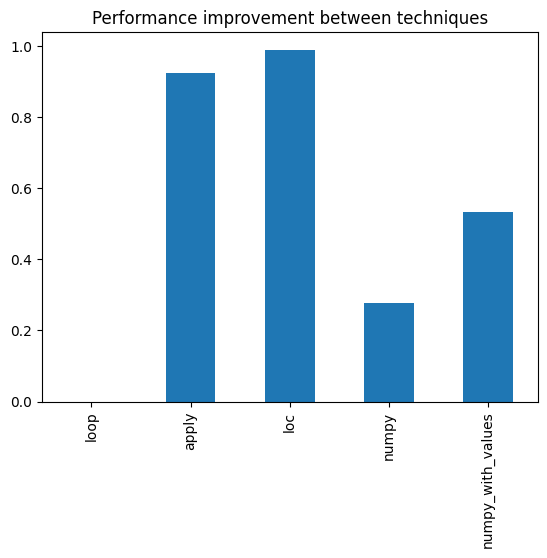

In [17]:
timings.pct_change(axis = 1).abs().mean().plot(kind = 'bar', title = 'Performance improvement between techniques')

So how fast are the vectorized functions? Well if we were to chart them we would have to use a logarithmic scale in order to appreciate it a little, since we are dealing with different magnitude levels (seconds to nanoseconds).

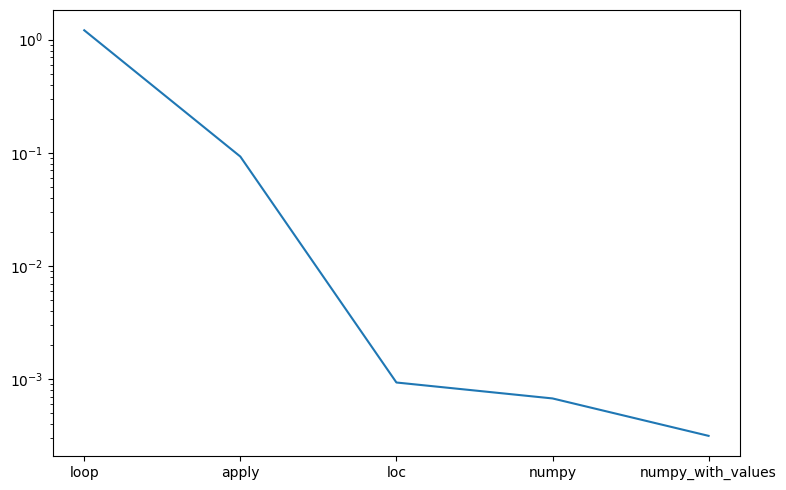

In [18]:
fig, ax = pyplot.subplots(1,1, figsize = (8,5), dpi = 100)
ax.plot(timings.mean())
ax.set_yscale('log')
fig.tight_layout()
pyplot.show()

Not bad! Now, even though this is useful intel our problems might not be this simple. I'd dare say a more real example would be having to apply multiple where conditions to our datasets (if..elif..elif..else..).

So our monkey brains would be tempted to dive right it into multiple nesting using numpy.where(). After all, there is something familiar about this, right? Where might have we seen this structure before...?

Yes, the answer is Excel. The pain... The atrocities... Instead of moving forward and improving ourselves we went back to the old ways in an instant. Why not develop a smoking habit while we are at it?

Look.

Let's say we want to classify our students based on test performance. We will classify them in 5 tiers. Failing, Barely Made It, Good, Excellent, Outstanding.

Tier Logic:
- > < 65: Failing
- >'>= 65 and <= 75: Barely Made It
- >'> 75 and <= 85: Good
- >'> 85 and <= 95: Excellent
- >'> 95: Outstanding

In [19]:
df['final_score'] = df[['test_1_score', 'test_2_score', 'test_3_score']].mean(axis = 1)

In [20]:
%%timeit
df['tier'] = \
    np.where(df['final_score'].values < 0.65, 'Failing',
    np.where((df['final_score'].values >= 0.65) & (df['final_score'].values <= 0.75), 'Barely Made It',
    np.where((df['final_score'].values > 0.75) & (df['final_score'].values <= 0.85), 'Good',
    np.where((df['final_score'].values > 0.85) & (df['final_score'].values <= 0.95), 'Excellent',
    'Outstanding'
))))

1.44 ms ± 6.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Yeah no, thanks. Even with my awesome formatting skills it feels bad, man. Add more complex logic and witness a new nightmare shape its form into your codebase. Quality Assurance will cry. Your peers will resent your presence. Your boss will begin talking about your bright future in the accounting department. Your girlfriend's boyfriend will want to meet your parents and hang out with you more frequently. All because you dared to shatter Guido's dream of a future where people learned to use python as intended. Now we all have to stay miserable because you didn't take a moment to learn about numpy.select() 

In [21]:
conditions = [
    df['final_score'].values < 0.65, 
    (df['final_score'].values >= 0.65) & (df['final_score'].values <= 0.75),
    (df['final_score'].values > 0.75) & (df['final_score'].values <= 0.85),
    (df['final_score'].values > 0.85) & (df['final_score'].values <= 0.95),
]

In [22]:
choices = [
    'Failing',
    'Barely Made It',
    'Good',
    'Excellent',
]

In [23]:
%%timeit
df['tier'] = np.select(conditions, choices, default='Outstanding')

1.14 ms ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Oooof. Crisis adverted. 

And hey, it's faster too!

You instantly feel much wiser. Your imagination is blown and you are going into places you dared dream before. Now, packed with this knowledge you are ready to face the world. You are ready to refactor all your codebase and start vectorizing your functions. Cannon to right of them, Cannon to left of them, Cannon in front of them, Volleyed and thundered! But, alas, all your hopes and fantasies about blowing people's heads got shut down in an instant because your dataset is too big and froze your laptop. 

Go to lesson 2.